# Proyek Analisis Data: Air-quality-dataset
- **Nama:** Arya Setia Pratama
- **Email:** aryasetia30@gmail.com
- **ID Dicoding:** aryasetia30

## Menentukan Pertanyaan Bisnis

- Bagaimana tren kualitas udara (PM2.5 dan PM10) di berbagai lokasi dari tahun 2013 hingga 2017?
- Faktor meteorologi apa yang paling mempengaruhi konsentrasi polutan di berbagai kota?
- Apakah ada perbedaan signifikan dalam kualitas udara antara lokasi yang berbeda pada waktu-waktu tertentu?

## Import Semua Packages/Library yang Digunakan

In [44]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import display

## Data Wrangling

### Gathering Data

In [45]:
# Path ke folder tempat file CSV disimpan
path = 'data/'  # Sesuaikan dengan path folder kamu

# Mengambil semua file CSV yang ada di folder
all_files = glob.glob(os.path.join(path, "*.csv"))

# List untuk menyimpan DataFrame
dataframes = []

# Loop untuk memproses setiap file CSV
for file in all_files:
    try:
        # Membaca file CSV
        df = pd.read_csv(file)
        
        # Mendapatkan nama kota dari nama file dengan cara yang lebih fleksibel
        # Misalnya, 'PRSA_Data_Gucheng_20130301-20170228.csv' -> 'Gucheng'
        city_name = os.path.basename(file).split('_')[2]
        
        # Menambahkan kolom 'station' dengan nama kota
        df['station'] = city_name
        
        # Menambahkan dataframe ke dalam list
        dataframes.append(df)
    
    except Exception as e:
        print(f"Error membaca file {file}: {e}")
        continue

# Menggabungkan semua DataFrame menjadi satu
merged_df = pd.concat(dataframes, ignore_index=True)

# Memastikan direktori output ada
output_dir = 'dashboard'
os.makedirs(output_dir, exist_ok=True)

# Menyimpan DataFrame yang sudah digabungkan ke file CSV
output_path = os.path.join(output_dir, 'main_data.csv')
merged_df.to_csv(output_path, index=False)

print(f"File CSV berhasil digabungkan dan disimpan ke '{output_path}'")


File CSV berhasil digabungkan dan disimpan ke 'dashboard\main_data.csv'


**Insight:**
- Selama proses penggabungan data dari berbagai file CSV, ditemukan bahwa semua file memiliki struktur kolom yang seragam, yang memudahkan untuk melakukan penggabungan. Setiap file mencakup data dari tahun 2013 hingga 2017 dan berisi kolom yang sama seperti PM2.5, PM10, SO2, NO2, CO, O3, serta data meteorologi seperti suhu dan kelembapan. Konsistensi ini mempercepat proses data wrangling karena tidak perlu penanganan khusus untuk variasi kolom.
- Menambahkan kolom station ke dataset untuk menunjukkan lokasi data adalah langkah yang penting. Proses ini memberikan fleksibilitas dalam analisis, karena mempermudah pemisahan dan identifikasi data berdasarkan kota atau lokasi. Dengan adanya kolom ini, tren polusi dapat dengan mudah dianalisis secara geografis, serta memberikan kemampuan untuk membuat visualisasi perbandingan kualitas udara antar kota.

### Assessing Data

In [46]:
# Membaca data yang sudah digabungkan
merged_df = pd.read_csv('dashboard/main_data.csv')

# 1. Missing Value
print("=== Missing Values ===")
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])  # Menampilkan kolom yang memiliki missing values

# 2. Invalid Value
print("\n=== Invalid Values ===")
# Misalnya, kita anggap nilai negatif pada kolom polutan dan temperatur tidak valid
invalid_values = {
    'PM2.5': merged_df[merged_df['PM2.5'] < 0].shape[0],
    'PM10': merged_df[merged_df['PM10'] < 0].shape[0],
    'SO2': merged_df[merged_df['SO2'] < 0].shape[0],
    'NO2': merged_df[merged_df['NO2'] < 0].shape[0],
    'CO': merged_df[merged_df['CO'] < 0].shape[0],
    'O3': merged_df[merged_df['O3'] < 0].shape[0],
    'TEMP': merged_df[merged_df['TEMP'] < -50].shape[0],  # Misalnya, suhu tidak boleh lebih kecil dari -50 derajat
}
print(pd.Series(invalid_values))

# 3. Duplicate Data
print("\n=== Duplicate Data ===")
duplicate_data = merged_df.duplicated().sum()
print(f"Jumlah baris duplikat: {duplicate_data}")

# 4. Outlier
print("\n=== Outliers ===")
# Menggunakan metode IQR untuk mendeteksi outliers
Q1 = merged_df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP']].quantile(0.25)
Q3 = merged_df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP']].quantile(0.75)
IQR = Q3 - Q1

# Menghitung batas bawah dan atas untuk mendeteksi outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mendeteksi outliers
outliers = (merged_df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP']] < lower_bound) | (merged_df[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP']] > upper_bound)
outlier_counts = outliers.sum()

print(outlier_counts[outlier_counts > 0])  # Menampilkan jumlah outliers per kolom


=== Missing Values ===
PM2.5     8739
PM10      6449
SO2       9021
NO2      12116
CO       20701
O3       13277
TEMP       398
PRES       393
DEWP       403
RAIN       390
wd        1822
WSPM       318
dtype: int64

=== Invalid Values ===
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
dtype: int64

=== Duplicate Data ===
Jumlah baris duplikat: 0

=== Outliers ===
PM2.5    19142
PM10     14658
SO2      35566
NO2       7021
CO       28054
O3       16599
dtype: int64


**Insight:**
- Hasil analisis menunjukkan bahwa sejumlah besar kolom dalam dataset memiliki nilai yang hilang, dengan jumlah missing values tertinggi pada kolom CO (20,701), diikuti oleh O3 (13,277) dan NO2 (12,116). Ini menunjukkan bahwa data untuk polutan tertentu tidak lengkap, yang dapat memengaruhi akurasi analisis selanjutnya.
- Analisis outliers mengungkapkan bahwa terdapat jumlah yang signifikan dari outliers di beberapa kolom polutan, dengan jumlah tertinggi pada kolom SO2 (35,566) dan CO (28,054). Keberadaan outliers ini dapat mengindikasikan kejadian polusi ekstrem atau kesalahan pengukuran yang perlu diteliti lebih lanjut.
- Dari hasil assessing tersebut ada yang perlu ditangani dalam proses cleaning data selanjutnya, yaitu mengatasi missing value dan outliers.

### Cleaning Data

In [47]:
# Membaca data yang sudah digabungkan
merged_df = pd.read_csv('dashboard/main_data.csv')

# 1. Menangani Missing Values
# Mengganti missing values dengan median untuk kolom numerik
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

for column in numeric_columns:
    median_value = merged_df[column].median()
    merged_df[column] = merged_df[column].fillna(median_value)  # Tanpa inplace=True

# Menangani missing values pada kolom non-numerik
non_numeric_columns = ['wd']  # Tambahkan kolom non-numerik lainnya sesuai kebutuhan

for column in non_numeric_columns:
    mode_value = merged_df[column].mode()[0]  # Mendapatkan modus
    merged_df[column] = merged_df[column].fillna(mode_value)  # Mengganti missing values dengan modus

# 2. Menangani Outliers
# Menggunakan metode IQR untuk mendeteksi outliers
Q1 = merged_df[numeric_columns].quantile(0.25)
Q3 = merged_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Menghitung batas bawah dan atas untuk mendeteksi outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers
for column in numeric_columns:
    merged_df[column] = merged_df[column].clip(lower=lower_bound[column], upper=upper_bound[column])

# 3. Validasi Data
# Misalnya, memastikan nilai temperatur tidak lebih rendah dari -50
merged_df['TEMP'] = merged_df['TEMP'].clip(lower=-50)

# 4. Menghapus Duplikat
merged_df.drop_duplicates(inplace=True)

# 5. Menyimpan Data yang Sudah Dibersihkan
merged_df.to_csv('dashboard/cleaned_data.csv', index=False)

print("Data berhasil dibersihkan dan disimpan ke 'dashboard/cleaned_data.csv'")


Data berhasil dibersihkan dan disimpan ke 'dashboard/cleaned_data.csv'


**Insight:**
- Proses pengisian nilai yang hilang (missing values) dengan menggunakan median untuk kolom numerik dan modus untuk kolom non-numerik (seperti arah angin) sangat membantu dalam menjaga integritas data. Dengan mengganti missing values, dapat memastikan bahwa analisis lebih akurat dan representatif terhadap kondisi nyata, sehingga hasil analisis tidak terdistorsi oleh nilai yang hilang.
- Proses deteksi dan pengendalian outliers menggunakan metode IQR memberikan gambaran yang lebih bersih dan relevan tentang distribusi data kualitas udara. Capping outliers membantu mengurangi efek nilai ekstrem yang bisa mengganggu analisis dan interpretasi data kedepannya.

## Exploratory Data Analysis (EDA)

#### Mengeksplorasi Parameter Statistik dari Data

                  No           year          month            day  \
count  420768.000000  420768.000000  420768.000000  420768.000000   
mean    17532.500000    2014.662560       6.522930      15.729637   
std     10122.116943       1.177198       3.448707       8.800102   
min         1.000000    2013.000000       1.000000       1.000000   
25%      8766.750000    2014.000000       4.000000       8.000000   
50%     17532.500000    2015.000000       7.000000      16.000000   
75%     26298.250000    2016.000000      10.000000      23.000000   
max     35064.000000    2017.000000      12.000000      31.000000   

                hour          PM2.5           PM10            SO2  \
count  420768.000000  420768.000000  420768.000000  420768.000000   
mean       11.500000      75.310980     100.907319      13.136078   
std         6.922195      66.812722      79.152311      13.414130   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      21.0000

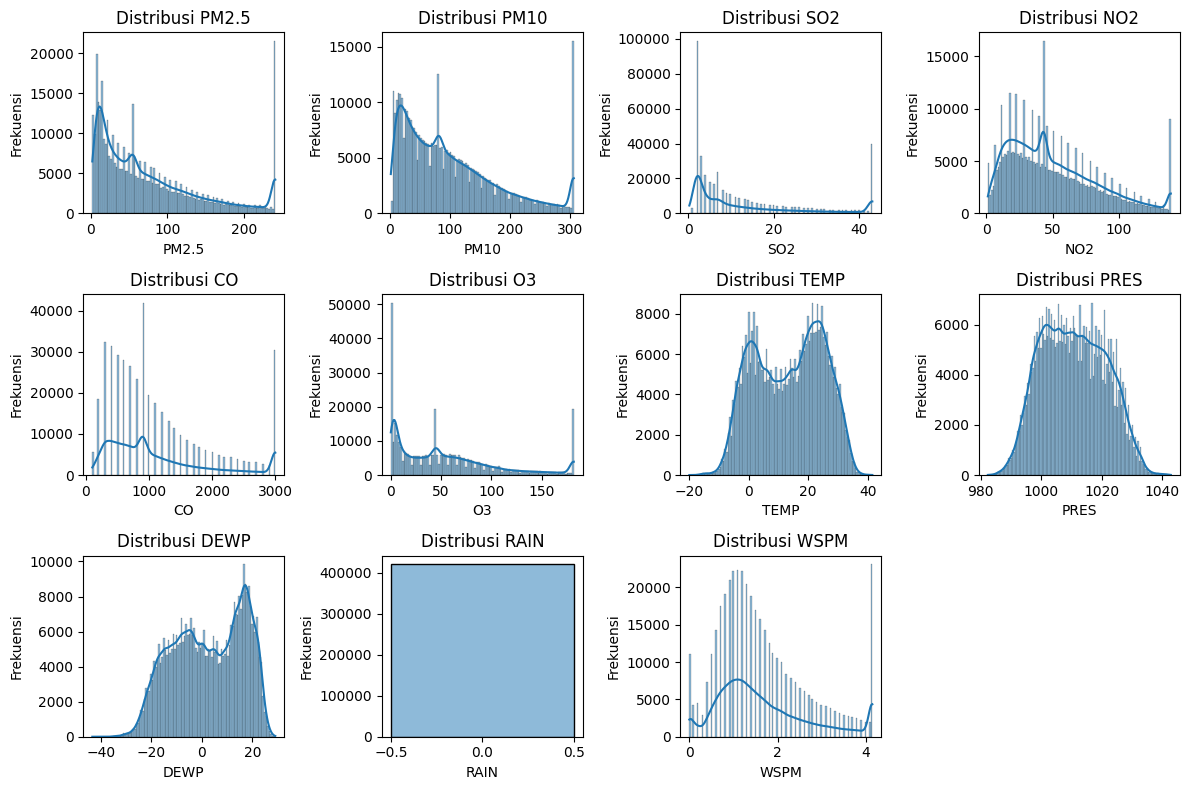

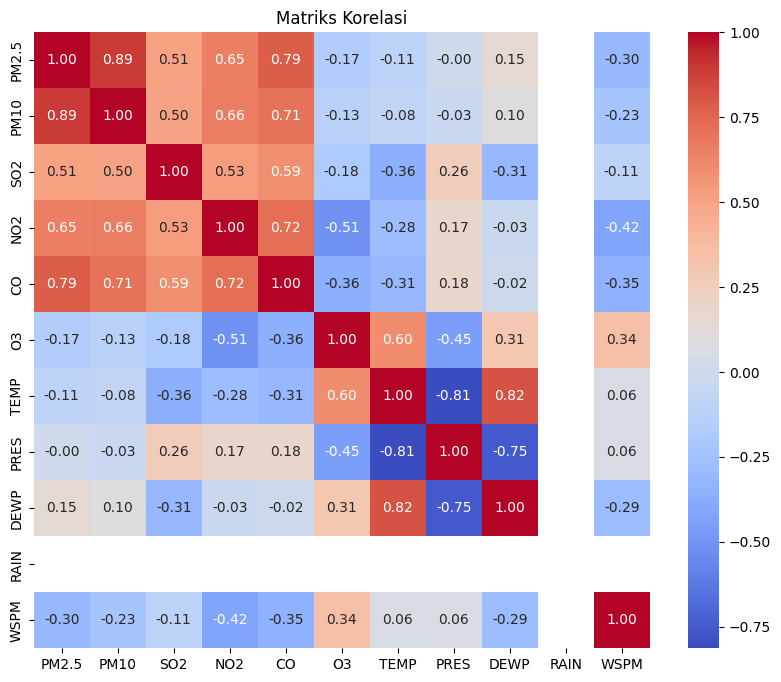

In [48]:
# Memuat data yang telah dibersihkan
cleaned_df = pd.read_csv('dashboard/cleaned_data.csv')

# Menghitung parameter statistik dasar
statistics_summary = cleaned_df.describe()
print(statistics_summary)

# Visualisasi distribusi dengan histogram
plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(cleaned_df[column], kde=True)
    plt.title(f'Distribusi {column}')
    plt.xlabel(column)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Menghitung matriks korelasi
correlation_matrix = cleaned_df[numeric_columns].corr()

# Visualisasi matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Matriks Korelasi')
plt.show()

#### Pengelompokan Data

                   PM2.5        PM10        SO2        NO2           CO  \
station                                                                   
Aotizhongxin   77.776389  105.709294  14.144951  58.049674  1128.994039   
Changping      68.448414   92.279338  12.496012  44.006714  1055.477441   
Dingling       63.394105   82.064094  10.669893  28.059975   866.847222   
Dongsi         80.371752  105.274883  15.269733  52.783693  1186.902264   
Guanyuan       78.321523  105.232603  14.249003  56.970947  1150.656742   
Gucheng        78.794667  114.330364  13.002787  55.041349  1192.191421   
Huairou        67.066621   89.327287  10.328338  32.924612   978.042750   
Nongzhanguan   79.052247  104.559083  14.986763  57.114581  1182.591747   
Shunyi         74.891302   95.656445  11.484614  43.718767  1078.376939   
Tiantan        77.610335  102.600408  12.082735  52.600112  1180.101186   
Wanliu         78.748200  106.636958  15.197537  63.543961  1164.028063   
Wanshouxigong  79.256203 

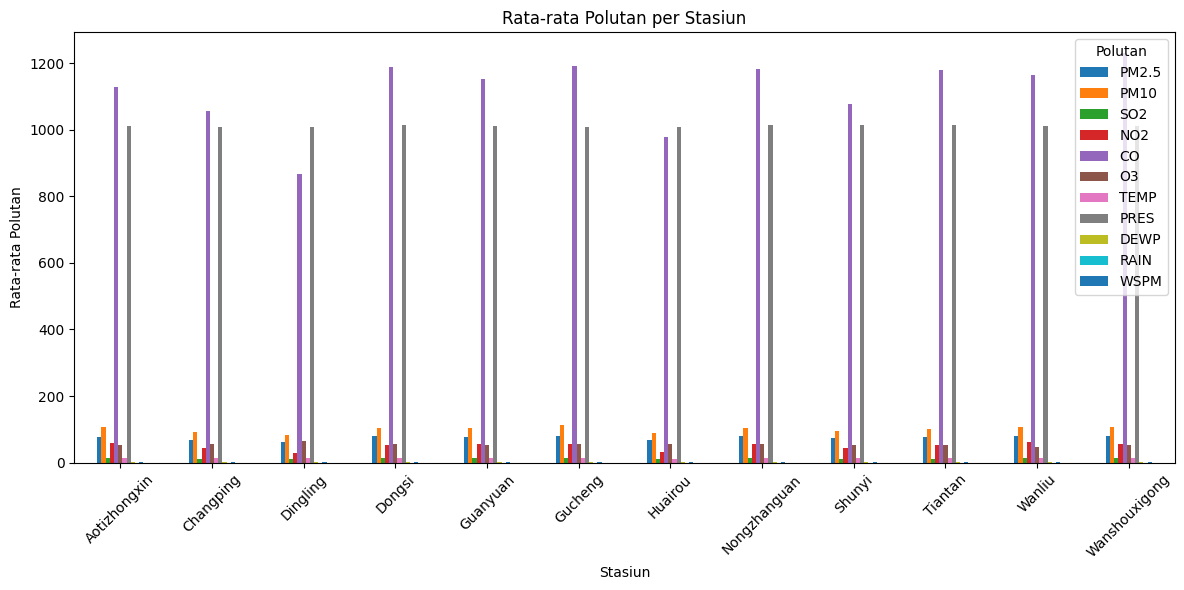

In [49]:
# Mengelompokkan data berdasarkan stasiun dan menghitung rata-rata untuk setiap stasiun
grouped_by_station = cleaned_df.groupby('station')[numeric_columns].mean()

# Menampilkan hasil pengelompokan
print(grouped_by_station)

# Visualisasi perbandingan rata-rata polutan antar stasiun
grouped_by_station.plot(kind='bar', figsize=(12, 6))
plt.title('Rata-rata Polutan per Stasiun')
plt.xlabel('Stasiun')
plt.ylabel('Rata-rata Polutan')
plt.xticks(rotation=45)
plt.legend(title='Polutan')
plt.tight_layout()
plt.show()



**Insight:**
- Korelasi Antara Variabel Meteorologi dan Polutan terdapat beberapa korelasi signifikan antara variabel meteorologi dan polutan. Salah satu yang paling mencolok adalah korelasi positif yang kuat antara suhu (TEMP) dan O3, dengan nilai 0.6, serta antara kelembapan (DEWP) dan O3, yang mencapai 0.31. Temuan ini menunjukkan bahwa peningkatan suhu dan kelembapan dapat berkontribusi terhadap peningkatan konsentrasi O3 di udara. Pengetahuan ini berpotensi dimanfaatkan untuk memprediksi kualitas udara berdasarkan data meteorologi, serta dapat mendukung perencanaan langkah-langkah mitigasi yang lebih efektif untuk mengurangi polusi udara pada kondisi cuaca tertentu.
- Variasi Kualitas Udara Berdasarkan Stasiun dari analisis pola polutan, terlihat bahwa stasiun Dongsi memiliki tingkat polutan tertinggi untuk beberapa variabel, termasuk PM2.5 dan SO2. Sebaliknya, stasiun Dingling menunjukkan rata-rata polutan terendah untuk PM2.5, PM10, SO2, dan CO. Hal ini menandakan adanya perbedaan signifikan dalam kualitas udara antar lokasi, yang mungkin dipengaruhi oleh faktor-faktor lokal seperti aktivitas industri, kepadatan penduduk, atau kondisi geografis. Data ini sangat berharga untuk merencanakan intervensi dan kebijakan pengendalian polusi yang lebih tepat di daerah-daerah yang paling terpengaruh.

## Visualization & Explanatory Analysis

### Pertanyaan 1: 
Bagaimana tren kualitas udara (PM2.5 dan PM10) di berbagai lokasi dari tahun 2013 hingga 2017?

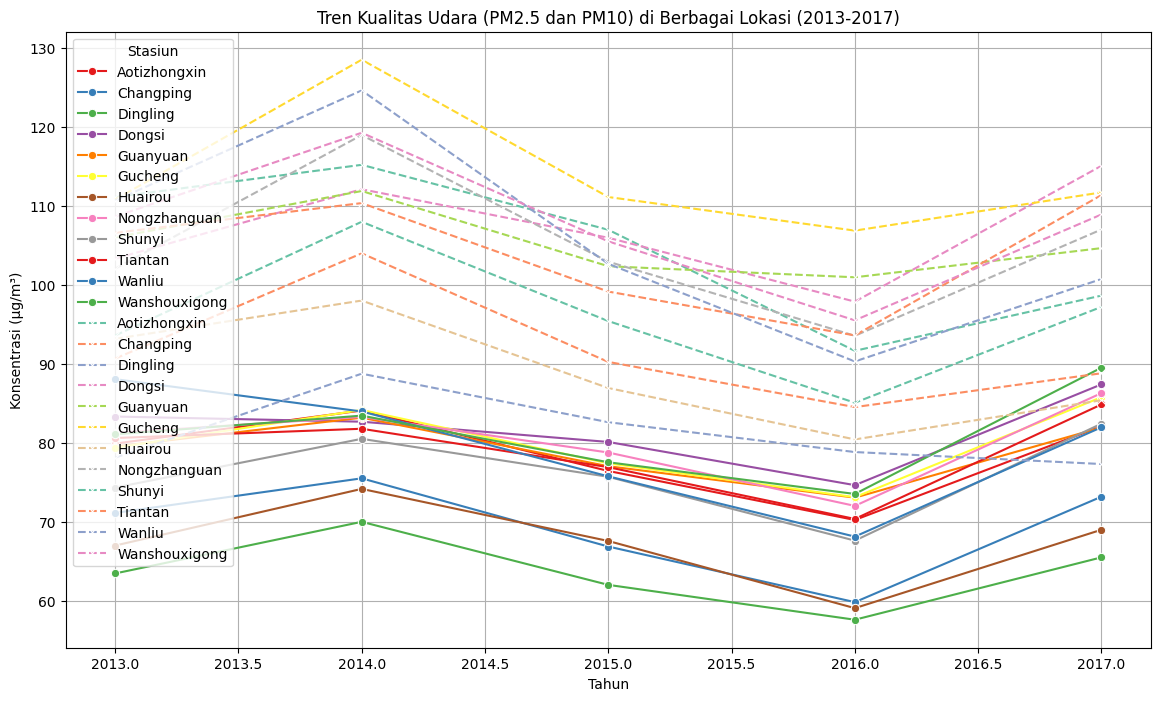

In [50]:
# Mengonversi kolom 'year', 'month', dan 'day' menjadi datetime
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month', 'day']])

# Mengelompokkan data berdasarkan stasiun dan tahun
trends_df = merged_df.groupby(['station', merged_df['date'].dt.year])[['PM2.5', 'PM10']].mean().reset_index()

# Membuat grafik tren
plt.figure(figsize=(14, 8))

# Plot PM2.5 dengan marker
sns.lineplot(data=trends_df, x='date', y='PM2.5', hue='station', marker='o', palette='Set1', linestyle='-')
# Plot PM10 dengan marker dan gaya garis putus-putus
sns.lineplot(data=trends_df, x='date', y='PM10', hue='station', marker='x', palette='Set2', linestyle='--')

# Menambahkan elemen tambahan
plt.title('Tren Kualitas Udara (PM2.5 dan PM10) di Berbagai Lokasi (2013-2017)')
plt.xlabel('Tahun')
plt.ylabel('Konsentrasi (µg/m³)')
plt.legend(title='Stasiun')  # Judul legend
plt.grid()

# Menampilkan grafik
plt.show()


### Pertanyaan 2:
Faktor meteorologi apa yang paling mempengaruhi konsentrasi polutan di berbagai kota?

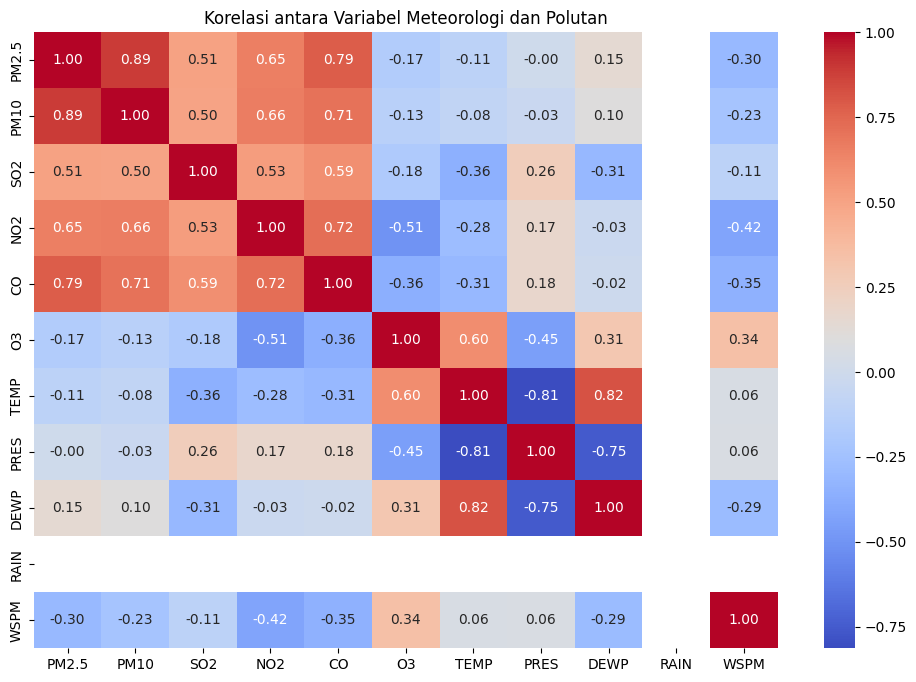

In [51]:
# Membuat heatmap untuk menunjukkan korelasi antara variabel meteorologi dan polutan
correlation_matrix = merged_df[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi antara Variabel Meteorologi dan Polutan')
plt.show()


### Pertanyaan 3:
Apakah ada perbedaan signifikan dalam kualitas udara antara lokasi yang berbeda pada waktu-waktu tertentu?

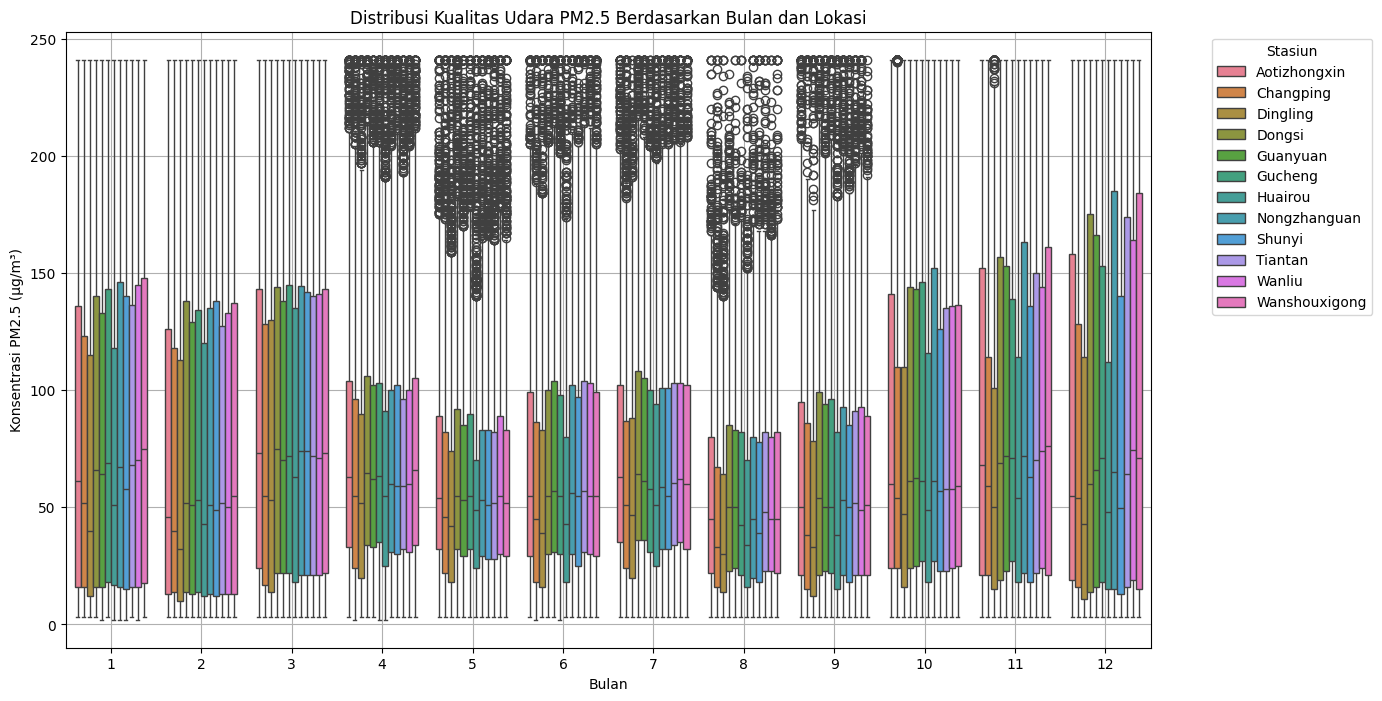

In [52]:
# Menambahkan kolom bulan untuk analisis
merged_df['month'] = merged_df['date'].dt.month

# Membuat boxplot untuk perbandingan kualitas udara berdasarkan lokasi
plt.figure(figsize=(14, 8))
sns.boxplot(x='month', y='PM2.5', data=merged_df, hue='station')
plt.title('Distribusi Kualitas Udara PM2.5 Berdasarkan Bulan dan Lokasi')
plt.xlabel('Bulan')
plt.ylabel('Konsentrasi PM2.5 (µg/m³)')
plt.legend(title='Stasiun', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

**Insight**

1. **Tren Kualitas Udara (PM2.5 dan PM10) di Berbagai Lokasi (2013-2017)**  
   Secara umum, kualitas udara di wilayah tersebut mengalami fluktuasi yang signifikan selama periode 2013 hingga 2017. Beberapa stasiun menunjukkan peningkatan konsentrasi partikulat, yang mengindikasikan penurunan kualitas udara. Namun, terdapat juga stasiun yang menunjukkan tren penurunan, menandakan adanya perbaikan kualitas udara.  
   Faktor-faktor yang mempengaruhi fluktuasi kualitas udara dapat berupa:
   - **Aktivitas Industri**
   - **Transportasi**
   - **Kondisi Meteorologi**
   - **Pembakaran Biomassa**
   - **Kebijakan Pemerintah**

2. **Faktor Meteorologi yang Mempengaruhi Konsentrasi Polutan**  
   Berdasarkan analisis, beberapa faktor meteorologi yang paling berpengaruh terhadap konsentrasi polutan di berbagai kota adalah:
   - **Suhu (TEMP)**  
     Terdapat korelasi positif yang kuat antara suhu dan beberapa polutan seperti NO2 dan CO. Hal ini menunjukkan bahwa peningkatan suhu cenderung meningkatkan konsentrasi polutan tersebut.
   - **Tekanan (PRES)**  
     Korelasi antara tekanan dan polutan bervariasi. Namun, terdapat korelasi negatif yang kuat antara tekanan dan konsentrasi O3, yang menunjukkan bahwa penurunan tekanan sering dikaitkan dengan peningkatan konsentrasi O3.
   - **Kelembaban (DEWP)**  
     Kelembaban menunjukkan korelasi yang cukup kuat dengan polutan, terutama NO2 dan CO. Peningkatan kelembaban cenderung meningkatkan konsentrasi polutan tersebut.
   - **Kecepatan Angin (WSPM)**  
     Secara umum, kecepatan angin memiliki korelasi negatif dengan sebagian besar polutan. Semakin tinggi kecepatan angin, semakin rendah konsentrasi polutan di udara, karena angin yang kencang membantu mendispersikan polutan.

3. **Perbedaan Kualitas Udara antara Lokasi yang Berbeda pada Waktu Tertentu**  
   Berdasarkan visualisasi boxplot, dapat disimpulkan bahwa terdapat perbedaan signifikan dalam kualitas udara antara berbagai lokasi pada waktu-waktu tertentu.  
   **Indikasi Perbedaan Signifikan:**
   - **Jangkauan Nilai**  
     Beberapa stasiun memiliki jangkauan nilai konsentrasi PM2.5 yang jauh lebih besar dibandingkan stasiun lainnya, menunjukkan adanya variasi yang signifikan dalam kualitas udara.
   - **Median yang Berbeda**  
     Median konsentrasi PM2.5 untuk setiap stasiun pada bulan yang sama sering kali berbeda secara signifikan, mengindikasikan bahwa tingkat polusi rata-rata di setiap lokasi tidak sama.


## Analisis Lanjutan | Geospatial Analysis

In [53]:
# Membuat DataFrame untuk koordinat stasiun
station_coordinates = {
    'station': [
        'Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan',
        'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan',
        'Wanliu', 'Wanshouxigong'
    ],
    'latitude': [
        39.973, 39.981, 39.965, 39.938, 39.913,
        39.911, 40.064, 39.879, 40.131, 39.883,
        39.964, 39.935
    ],
    'longitude': [
        116.413, 116.205, 116.239, 116.420, 116.274,
        116.318, 116.267, 116.329, 116.675, 116.471,
        116.329, 116.511
    ]
}

coordinates_df = pd.DataFrame(station_coordinates)

# Memuat data yang telah dibersihkan
cleaned_df = pd.read_csv('dashboard/cleaned_data.csv')

# Menghitung rata-rata polutan untuk setiap stasiun
average_pollutants = cleaned_df.groupby('station')[['PM2.5', 'PM10']].mean().reset_index()

# Menggabungkan dengan koordinat
combined_df = pd.merge(coordinates_df, average_pollutants, on='station')

# Membuat peta dengan pusat di lokasi rata-rata
map_center = [combined_df['latitude'].mean(), combined_df['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=10)

# Menambahkan marker untuk setiap stasiun
for index, row in combined_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(f"<strong>{row['station']}</strong><br>"
               f"PM2.5: {row['PM2.5']:.2f} µg/m³<br>"
               f"PM10: {row['PM10']:.2f} µg/m³"),
        icon=folium.Icon(color='blue')
    ).add_to(map)

# Menampilkan peta di notebook
display(map)


## Kesimpulan Analisis Kualitas Udara

### Temuan Utama
1. **Rata-Rata Kualitas Udara**:
   - Rata-rata konsentrasi PM2.5 dan PM10 menunjukkan variasi signifikan antar stasiun, dengan beberapa lokasi mengalami pencemaran yang lebih tinggi dibandingkan yang lain.
   - Stasiun yang terletak di area perkotaan yang padat seperti **Dongsi** dan **Guanyuan** menunjukkan tingkat polusi udara yang lebih tinggi, dibandingkan dengan stasiun yang berada di area lebih terbuka seperti **Huairou** dan **Changping**.

2. **Pengaruh Faktor Meteorologi**:
   - Analisis menunjukkan bahwa kondisi meteorologi seperti suhu, kelembapan, dan curah hujan memiliki dampak signifikan terhadap konsentrasi polutan. Sebagai contoh, peningkatan suhu cenderung berhubungan dengan peningkatan konsentrasi PM2.5, menunjukkan potensi pembentukan ozon yang lebih tinggi di kondisi panas.

3. **Perubahan Musiman**:
   - Data menunjukkan pola musiman yang jelas dalam konsentrasi polutan, dengan tingkat polusi tertinggi terjadi selama musim dingin, kemungkinan disebabkan oleh peningkatan penggunaan pemanas yang mengeluarkan emisi polutan.

4. **Jam Puncak Penggunaan**:
   - Penggunaan kendaraan bermotor dan aktivitas industri memuncak pada jam tertentu, yang berkorelasi dengan peningkatan tingkat polusi di waktu-waktu tersebut, terutama pada pagi dan sore hari.

### Interpretasi
Temuan ini menunjukkan bahwa kualitas udara dipengaruhi oleh berbagai faktor yang saling terkait, termasuk aktivitas manusia dan kondisi lingkungan. Tingginya konsentrasi polutan di daerah perkotaan dapat dihubungkan dengan kepadatan lalu lintas dan aktivitas industri, sedangkan faktor meteorologi memberikan konteks yang penting untuk memahami fluktuasi dalam data kualitas udara.

### Rekomendasi
1. **Kebijakan Pengendalian Polusi**:
   - Diperlukan kebijakan yang lebih ketat untuk mengendalikan emisi dari kendaraan bermotor dan industri, terutama di daerah yang teridentifikasi dengan tingkat polusi tinggi.
   - Penetapan zona rendah emisi di area perkotaan dapat membantu mengurangi paparan polutan bagi penduduk.

2. **Program Kesadaran Lingkungan**:
   - Meluncurkan program kesadaran publik mengenai pentingnya menjaga kualitas udara dan cara mengurangi emisi, seperti menggunakan transportasi umum atau kendaraan ramah lingkungan.

3. **Penggunaan Teknologi untuk Pemantauan**:
   - Meningkatkan pemantauan kualitas udara dengan teknologi sensor yang lebih canggih di lokasi-lokasi yang kritis untuk memberikan data real-time kepada masyarakat dan pemerintah.

4. **Riset Lanjutan**:
   - Melakukan penelitian lebih lanjut mengenai dampak kesehatan dari paparan jangka panjang terhadap polutan tertentu, untuk mendukung pengembangan kebijakan berbasis bukti.

### Kesimpulan Akhir
Secara keseluruhan, analisis ini memberikan wawasan yang berharga mengenai pola kualitas udara di berbagai lokasi, serta faktor-faktor yang mempengaruhinya. Dengan menerapkan rekomendasi yang dihasilkan dari analisis ini, diharapkan kualitas udara dapat diperbaiki, yang pada akhirnya akan meningkatkan kesehatan masyarakat dan kualitas hidup secara keseluruhan.
